# NAIRU + Output Gap Model

## Notebook layout:

This notebook has a number of sections:
* Initial python set-up
* Primary data capture - includes plotting input data
* Building an observations table for the Bayesian modelling process
* Defining and fitting the model, checking the Bayesian/HMC diagnostics after the model has run
* Validating the model coefficients - differ from zero - theoretically sound
* Plotting the results

See the [documentation file for more information](<NAIRU+Output Gap model.md>)

## Python set-up

In [1]:
# system imports
from typing import cast, Sequence
import math

In [2]:
# Analytic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.axes import Axes
from IPython.display import display
from readabs import read_abs_series, read_rba_table
from scipy import stats

In [3]:
# local imports
import mgplot as mg 
import henderson
from abs_structured_capture import ReqsDict, ReqsTuple, get_abs_data

In [4]:
# Plotting set-up
CHART_DIR = "./CHARTS/NAIRU-YGAP/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

RFOOTER = "ABS: 1364.0.15.003"
RFOOTER_OUTPUT = "Joint NAIRU + Output Gap model."

# display charts in this notebook
SHOW = False

## Data capture

#### Utility

In [5]:
def annual_to_quarterly(annual_rate: pd.Series) -> pd.Series:
    """Convert annual inflation expectations to quarterly.
    Formula: ((1 + annual_rate/100)^(1/4) - 1) * 100"""
    return ((1 + annual_rate / 100) ** (1/4) - 1) * 100

In [6]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of
    the three months in each quarter. Ignore quarters with less than
    three months data. Drop NA items."""

    return (
        data.groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(["mean", "count"])
        .apply(lambda x: x["mean"] if x["count"] == 3 else np.nan, axis=1)
        .dropna()
    )

In [7]:
# plot the 2.5% annual inflation target in quarterly terms

QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}

ANNUAL_RANGE = {
    "axhspan": {
        "ymin": 2,
        "ymax": 3,
        "color": "#dddddd",
        "label": "2-3% annual inflation target range",
        "zorder": -1,
    }
}

ANNUAL_TARGET = {
    "axhline": {
        "y": 2.5,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "2.5% annual inflation target",
    }
}

#### Unemployment rate

In [8]:
def get_unemployment() -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, the change in the UE rate, and labor force growth."""

    wanted: ReqsDict = {
        # ReqsTupleL cat, table, did, stype, unit, seek_yr_growth, calc_growth, zip_file
        "Labor Force": 
            ReqsTuple("1364.0.15.003", "1364015003", "Total labour force ;", "S", "", False, False, ""),
        "Unemployed":
            ReqsTuple("1364.0.15.003", "1364015003", "Total unemployed ;", "S", "", False, False, ""),
    }
    data = get_abs_data(wanted)
    u = (data["Unemployed"] / data["Labor Force"]) * 100
    u.name = "Unemployment Rate"

    # calculate the change in the UE rate as a proportion of the UE rate
    delta_u = u.diff(1)
    delta_u.name = "Change in Unemployment Rate (ΔU)",
    delta_u_1 = delta_u.shift(1)

    # calculate labor force growth (4Q log difference, then quarterised)
    # This captures population growth + participation rate changes, smoothed
    lf_growth_annual = np.log(data["Labor Force"]).diff(4) * 100
    lf_growth_raw = annual_to_quarterly(lf_growth_annual)

    # Apply Henderson moving average and substitute for COVID period
    # to remove the extreme spike/dip distortions
    lf_growth_henderson = henderson.hma(lf_growth_raw.dropna(), 13)
    replace = pd.period_range("2020Q1", "2023Q2", freq="Q")
    lf_growth_henderson = henderson.hma(lf_growth_raw.dropna(), 13)
    lf_growth = lf_growth_raw.where(~lf_growth_raw.index.isin(replace), other=lf_growth_henderson)

    # Plot the data
    common_format = {
        "lfooter": "Australia. Seasonally adjusted series. Quarterly data. ",
        "rfooter": RFOOTER,
        "show": SHOW,
        "y0": True,
    }

    mg.line_plot_finalise(
        u,
        ylabel="Per cent of Labour Force",
        title="Unemployment Rate",
        **common_format,
    )

    mg.line_plot_finalise(
        delta_u,
        ylabel="Q/Q Percentage points",
        title="Change in Unemployment Rate (ΔU)",
        **common_format,
    )

    # Plot both original and COVID-adjusted labor force growth
    lf_plot_df = pd.DataFrame({
        "Original": lf_growth_raw,
        "COVID-adjusted": lf_growth,
    })
    ax = mg.line_plot(
        lf_plot_df,
        width=2,
    )
    ax.legend(loc="upper right", fontsize="small")
    mg.finalise_plot(
        ax,
        title="Labor Force Growth",
        ylabel="Q/Q Per cent",
        lfooter="Australia. 4Q labor force growth, quarterised. Henderson MA (13-term) substituted for 2020Q1-2023Q2. ",
        rfooter=RFOOTER,
        show=SHOW,
        y0=True,
    )

    # return the values (using COVID-adjusted for the model)
    return u, delta_u, delta_u_1, lf_growth


U, ΔU, ΔU_1, LF_growth = get_unemployment()

#### Real GDP

In [9]:
def get_real_gdp() -> tuple[pd.Series, pd.Series]:
    """Get real GDP from ABS National Accounts (5206.0).
    Returns log GDP and quarterly GDP growth."""

    # A2304402X = GDP Chain Volume Measures, Seasonally Adjusted
    nat_accounts, _meta = read_abs_series(cat="5206.0", series_id="A2304402X")
    real_gdp = nat_accounts["A2304402X"]
    
    # Log GDP (for output gap estimation)
    log_gdp = real_gdp.apply(np.log) * 100  # multiply by 100 for percentage scale
    
    # Quarterly GDP growth
    gdp_growth = log_gdp.diff(1)
    
    # Plot
    mg.line_plot_finalise(
        real_gdp,
        title="Real GDP (Chain Volume)",
        ylabel="$ millions",
        lfooter="Australia. Seasonally adjusted. ",
        rfooter="ABS 5206.0",
        show=SHOW,
    )
    
    mg.line_plot_finalise(
        gdp_growth,
        title="Quarterly Real GDP Growth",
        ylabel="Per cent (log difference)",
        lfooter="Australia. Seasonally adjusted. ",
        rfooter="ABS 5206.0",
        y0=True,
        show=SHOW,
    )
    
    return log_gdp, gdp_growth


log_GDP, GDP_growth = get_real_gdp()

#### Labour Productivity (for time-varying potential growth)

In [10]:
def get_productivity_trend(trend_weight: float = 0.75) -> pd.Series:
    """Get labour productivity (GDP per hour worked) and calculate
    a blended measure of linear trend and raw productivity growth.

    This is used to inform time-varying potential GDP growth, based on
    the idea that productivity doesn't matter in the short run but is
    everything in the long run.

    Args:
        trend_weight: Weight on linear trend (default 0.75, remainder on raw)

    Returns:
        Blended quarterly productivity growth (trend_weight × linear + (1-trend_weight) × raw)
    """

    # GDP per hour worked from National Accounts - use data item descriptions
    wanted: ReqsDict = {
        "GDP": ReqsTuple(
            "5206.0", "5206001_Key_Aggregates",
            "Gross domestic product: Chain volume measures ;",
            "S", "", False, False, ""
        ),
        "Hours": ReqsTuple(
            "5206.0", "5206001_Key_Aggregates",
            "Hours worked: Index ;",
            "S", "", False, False, ""
        ),
    }
    data = get_abs_data(wanted)
    productivity_index = data["GDP"] / data["Hours"]

    # Calculate quarterly productivity growth (log difference * 100 for percentage)
    log_productivity = productivity_index.apply(np.log) * 100
    productivity_growth = log_productivity.diff(1).dropna()

    # Fit linear trend through productivity growth
    x = np.arange(len(productivity_growth))
    slope, intercept = np.polyfit(x, productivity_growth.values, 1)
    linear_trend = pd.Series(intercept + slope * x, index=productivity_growth.index)
    
    # Blend: trend_weight × linear + (1 - trend_weight) × raw
    raw_weight = 1 - trend_weight
    productivity_blend = trend_weight * linear_trend + raw_weight * productivity_growth

    # Plot
    fig, ax = plt.subplots()
    productivity_growth.plot(ax=ax, label="Quarterly productivity growth", alpha=0.5, lw=1)
    linear_trend.plot(ax=ax, label=f"Linear trend (slope: {slope*4:.3f}pp/yr)", lw=1.5, color="darkorange", ls="--")
    productivity_blend.plot(ax=ax, label=f"Blended ({int(trend_weight*100)}% trend)", lw=2, color="darkgreen")
    mg.finalise_plot(
        ax,
        title=f"Labour Productivity Growth ({int(trend_weight*100)}% linear trend / {int(raw_weight*100)}% raw)",
        ylabel="Per cent (quarterly)",
        lfooter="Australia. GDP per hour worked. Seasonally adjusted.",
        rfooter="ABS 5206.0",
        y0=True,
        legend={"loc": "upper right", "fontsize": "x-small"},
        show=SHOW,
    )

    return productivity_blend


productivity_trend = get_productivity_trend(trend_weight=0.75)

#### Inflation

In [11]:
def get_inflation(measure="TM"
) -> tuple[pd.Series, pd.Series]:
    """Get trimmed mean inflation as a measure of core inflation."""

    # -- will need a rework when the CPI is updated in late January 2026 --
    tm = "Percentage Change from Previous Period ;  Trimmed Mean ;  Australia ;"
    tm_annual = "Percentage Change from Corresponding Quarter of Previous Year ;  Trimmed Mean ;  Australia ;" 
    headline = "Percentage Change from Previous Period ;  All groups CPI, seasonally adjusted ;  Australia ;"
    old_cpi = "./ABS-Data/Qrtly-CPI-Time-series-spreadsheets-all.zip"
    wanted = {
    "Trimmed Mean" :
        ReqsTuple("", "640106", tm, "S", "", False, False, old_cpi),
    "Trimmed Mean Annual" :
        ReqsTuple("", "640106", tm_annual, "S", "", False, False, old_cpi),
    "Headline CPI" :
        ReqsTuple("", "640106", headline, "S", "", False, False, old_cpi),
    }
    selected = "Trimmed Mean" if measure == "TM" else "Headline CPI"
    inflation = get_abs_data(wanted)[selected]
    inflation.name = selected  # name for the graphs

    mg.line_plot_finalise(
        inflation,
        title="Q/Q Inflation",
        ylabel="Q/Q Percentage change",
        lfooter=f"Australia. Seasonally adjusted series. Quarterly data. {selected}",
        rfooter="ABS",
        show=SHOW,
        y0=True,
        tag="qtr",
        legend=True,
        axhspan=QUARTERLY_RANGE["axhspan"],
    )

    pi4 = get_abs_data(wanted)[f"{selected} Annual"]
    pi = inflation
    return pi, pi4


π, π4 = get_inflation()

#### Capital Stock (for Cobb-Douglas production function)

In [12]:
def get_capital_growth() -> pd.Series:
    """Get capital stock growth from ABS modellers database.
    
    Uses net capital stock of non-financial and financial corporations
    (chain volume measures) as a measure of productive business capital.
    
    Returns:
        Quarterly capital stock growth (log difference * 100)
    """
    
    wanted: ReqsDict = {
        "Capital": ReqsTuple(
            "1364.0.15.003", "1364015003",
            "Non-financial and financial corporations ; Net capital stock (Chain volume measures) ;",
            "S", "", False, False, ""
        ),
    }
    data = get_abs_data(wanted)
    capital = data["Capital"]
    
    # Calculate quarterly capital growth (log difference * 100 for percentage)
    log_capital = capital.apply(np.log) * 100
    capital_growth_raw = log_capital.diff(1).dropna()
    
    # Apply Henderson smoothing to remove noise (capital stock is slow-moving)
    capital_growth = henderson.hma(capital_growth_raw, 13)
    capital_growth.name = "Capital Growth"
    
    # Plot
    fig, ax = plt.subplots()
    capital_growth_raw.plot(ax=ax, label="Raw quarterly growth", alpha=0.5, lw=1)
    capital_growth.plot(ax=ax, label="Henderson MA (13-term)", lw=2, color="darkgreen")
    
    # Add annual growth rate annotation
    annual_growth = capital_growth.iloc[-4:].sum()
    ax.annotate(
        f"{annual_growth:.2f}% p.a.",
        xy=(capital_growth.index[-1], capital_growth.iloc[-1]),
        xytext=(10, 0),
        textcoords="offset points",
        fontsize=9,
        color="darkgreen",
    )
    
    mg.finalise_plot(
        ax,
        title="Capital Stock Growth",
        ylabel="Per cent (quarterly)",
        lfooter="Australia. Net capital stock of non-financial and financial corporations. Chain volume measures.",
        rfooter="ABS Modellers Database",
        y0=True,
        legend={"loc": "upper right", "fontsize": "x-small"},
        show=SHOW,
    )
    
    return capital_growth


capital_growth = get_capital_growth()

#### Multi-factor Productivity (for Cobb-Douglas production function)

In [13]:
def get_mfp_growth() -> pd.Series:
    """Get multi-factor productivity (MFP) growth for Cobb-Douglas production function.
    
    This function constructs a quarterly MFP growth series for use in the potential
    output equation. MFP measures technological progress and efficiency gains that
    aren't attributable to capital or labor inputs.
    
    Data source:
        ABS 5204.0 Table 13 - "Multifactor productivity - Hours worked: Percentage changes"
        Annual data, Original series, Market sector
    
    Processing steps:
        1. Fetch annual MFP growth from ABS 5204
        2. Apply Henderson MA (25-term) to smooth year-to-year volatility
        3. Convert annual growth to quarterly contribution (÷4)
        4. Interpolate to quarterly frequency
        5. Backfill pre-1995 periods with labour productivity trend (productivity_trend)
           where MFP data is unavailable
    
    The hybrid approach is necessary because:
        - ABS MFP data only begins ~1995
        - Model requires data back to 1985 for full sample estimation
        - Labour productivity serves as a reasonable proxy for earlier periods
    
    Returns:
        pd.Series: Quarterly MFP growth rate (per cent per quarter), indexed by
                   period. Values represent the MFP contribution to potential
                   GDP growth each quarter.
    
    Note:
        Mean annual MFP growth is ~0.7% (1995-2024), declining from ~2.3% in
        late 1990s to ~0% currently, reflecting Australia's productivity slowdown.
    """
    
    def fill(series: pd.Series, freq: str) -> pd.Series:
        s = series.sort_index()
        full_idx = pd.period_range(s.index[0], s.index[-1], freq=freq)
        return s.reindex(full_idx).interpolate()

    wanted: ReqsDict = {
        "MFP": ReqsTuple(
            "5204.0", "5204013_Productivity",
            "Multifactor productivity - Hours worked: Percentage changes ;",
            "O", "", False, False, ""
        ),
    }
    data = get_abs_data(wanted)
    mfp_annual = data["MFP"]
    n = 25
    mfp_annual_hma = henderson.hma(mfp_annual.dropna(), n)

    annual = pd.DataFrame(
        {
            "Raw Annual MFP Growth": mfp_annual,
            f"Henderson MA ({n}-term)": mfp_annual_hma,
        }
    )
    # Plot annual MFP with Henderson MA
    mg.line_plot_finalise(
        annual,
        title="Annual Multi-factor Productivity (MFP) Growth",
        ylabel="Per cent per annum",
        lfooter="Australia. Market sector. Hours worked basis.",
        rfooter="ABS 5204.0 Table 13",
        y0=True,
        legend={"loc": "best", "fontsize": "x-small"},
        width=[1,2],
        show=SHOW,
    )

    # Convert annual percentage to quarterly contribution
    # Annual growth of X% means roughly X/4% per quarter
    mfp_quarterly_rate = annual_to_quarterly(mfp_annual_hma)
    mfp_quarterly_rate = (
        mfp_quarterly_rate.to_timestamp(how="end")
        .resample("QE-DEC")
        .last()  
        .to_period("Q-DEC")
    ).interpolate()
    mfp_quarterly_rate = mfp_quarterly_rate.reindex(productivity_trend.index)
    mfp_final = mfp_quarterly_rate.where(mfp_quarterly_rate.notna(), other=productivity_trend)
    print("MFP Growth:")
    print(mfp_quarterly_rate.head(), mfp_quarterly_rate.tail())
    print("Productivity trend:")
    print(productivity_trend.head(), productivity_trend.tail())
    print("Final MFP Quarterly Rate:")
    print(mfp_final.head(), mfp_final.tail())

    mg.line_plot_finalise(
        mfp_final,
        title="Final MFP Quarterly Rate",
        ylabel="Per cent (quarterly)",
        lfooter="Australia. MFP quarterly growth rate used in model.",
        y0=True,
        show=SHOW,
    )

    
    return mfp_final


mfp_growth = get_mfp_growth()

MFP Growth:
Series ID
1978Q4   NaN
1979Q1   NaN
1979Q2   NaN
1979Q3   NaN
1979Q4   NaN
Freq: Q-DEC, Name: A2421374T, dtype: float64 Series ID
2024Q3    0.018909
2024Q4    0.014069
2025Q1    0.009229
2025Q2    0.004389
2025Q3    0.004389
Freq: Q-DEC, Name: A2421374T, dtype: float64
Productivity trend:
Series ID
1978Q4    0.514707
1979Q1    0.937401
1979Q2   -0.563923
1979Q3    0.799691
1979Q4    0.578268
Freq: Q-DEC, dtype: float64 Series ID
2024Q3   -0.005267
2024Q4    0.129920
2025Q1    0.160817
2025Q2    0.200697
2025Q3    0.163217
Freq: Q-DEC, dtype: float64
Final MFP Quarterly Rate:
Series ID
1978Q4    0.514707
1979Q1    0.937401
1979Q2   -0.563923
1979Q3    0.799691
1979Q4    0.578268
Freq: Q-DEC, Name: A2421374T, dtype: float64 Series ID
2024Q3    0.018909
2024Q4    0.014069
2025Q1    0.009229
2025Q2    0.004389
2025Q3    0.004389
Freq: Q-DEC, Name: A2421374T, dtype: float64


#### Import prices (from ABS 6457)

In [14]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade, _trade_meta = read_abs_series(cat="6457.0", series_id="A2298279F")
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    dlip_1 = delta4_log_import_prices.shift(periods=1).dropna()
    dlip_2 = delta4_log_import_prices.shift(periods=2).dropna()

    # plot the data
    ax = dlip_1.plot(lw=2)
    mg.finalise_plot(
        ax,
        title="Lagged change in import prices (Δ4ρm_1)",
        ylabel="diff(log(Import Price Index))*100",
        y0=True,
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 6457",
        show=SHOW,
    )

    return dlip_1, dlip_2


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()

Table 64570DO001 has no 'Index' sheet.
Table 64570DO002 has no 'Index' sheet.
Table 64570DO003 has no 'Index' sheet.


#### Unit labour costs

In [15]:
def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts, _nat_accounts_meta = read_abs_series(
        cat="5206.0", series_id=["A2304402X", "A2302915V"]
    )
    ulc = nat_accounts["A2302915V"] / nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100

    # plot the data
    term = 13
    trend = henderson.hma(delta_ulc, term)
    mg.line_plot_finalise(
        pd.DataFrame(
            {
                "Qrtly unit labour costs growth": delta_ulc,
                f"{term}-term Henderson moving average": trend,
            }
        ),
        title="Qrtly unit labour costs growth",
        ylabel="diff(log(ULC))*100",
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 5206",
        width=[1.5, 2.5],
        y0=True,
        show=SHOW,
    )
    return delta_ulc


Δulc = get_ulc()

#### Global supply constraints during the COVID-19 period

In [16]:
def get_gscpi() -> tuple[pd.Series, pd.Series]:
    """Global Supply Chain Price Index. Useful for capturing global supply constraints
    associated with the COVID-19 pandemic (and subsequent reopening and the Ukraine war).
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls",
        sheet_name="GSCPI Monthly Data",
        index_col=0,
        parse_dates=True,
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    quarter = pd.Timestamp.today().to_period('Q')
    dummy = pd.Series(1, pd.period_range(start="1959Q1", end=quarter-1, freq="Q"))
    mask = (dummy.index >= "2020Q1") & (dummy.index <= "2023Q2")
    dummy[mask] = 0  # - key dates for the COVID period
    gscpi_1 = gscpi_1.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)
    gscpi_2 = gscpi_2.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)

    mg.line_plot_finalise(
        gscpi,
        title="Global supply constraints",
        ylabel="Index",
        lfooter="Quarterly data. ",
        rfooter="Source: New York Fed",
        width=2,
        y0=True,
        show=SHOW,
    )

    return gscpi_1, gscpi_2


ξ_1, ξ_2 = get_gscpi()

#### Oil price shocks

In [17]:
def get_oil_shock() -> pd.Series:
    """Get oil price shocks for the full sample period.
    Uses World Bank crude oil prices (average of Brent, Dubai, WTI) converted to AUD.
    Returns quarterly log change in AUD oil prices."""
    
    # Get USD oil prices from World Bank Pink Sheet - Historical Data
    url = (
        "https://thedocs.worldbank.org/en/doc/" +
        "18675f1d1639c7a34d463f59263ba0a2-0050012025/related/CMO-Historical-Data-Monthly.xlsx"
    )
    commodities: pd.DataFrame = pd.read_excel(
        url, sheet_name="Monthly Prices", header=6, na_values=['N/A', 'missing', '-', '…'], index_col=0
    )

    oil_monthly: pd.Series = (
        commodities['CRUDE_PETRO']  # international average price
        .astype(float)
    )
    oil_monthly.index = oil_monthly.index.str.replace('M', '-')
    oil_monthly.index = pd.PeriodIndex(oil_monthly.index, freq="Q")

    oil_quarterly: pd.Series = oil_monthly.groupby(oil_monthly.index).mean()

    hist_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist-1969-2009.xls"
    now_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist.xls"

    container = []
    for url in [hist_url, now_url]:
        table = pd.read_excel(url, sheet_name="Data", header=10, index_col=0)
        series: pd.Series = table["FXRUSD"].dropna()
        series.index = pd.PeriodIndex(series.index, freq="Q")
        series = series.groupby(series.index).mean()
        container.append(series)

    aud_usd = pd.concat(container)
    
    # Convert oil to AUD: USD_price / (AUD/USD) = AUD_price
    oil_aud: pd.Series = oil_quarterly.div(aud_usd).dropna()

    # Calculate quarterly log change (percentage change)
    log_oil_aud = oil_aud.apply(np.log)
    delta_log_oil = (log_oil_aud.diff(1) * 100).dropna()
    
    mg.line_plot_finalise(
        delta_log_oil,
        title="Quarterly change in AUD oil prices",
        ylabel="percent change (log difference)",
        lfooter="Quarterly data. World Bank crude oil prices converted to AUD.",
        rfooter="World Bank, RBA",
        width=2,
        y0=True,
        show=SHOW,
    )
    
    return delta_log_oil


oil_shock = get_oil_shock()

#### RBA Cash Rate

In [18]:
def get_rba_cash_rate() -> tuple[pd.Series, pd.Series]:
    """Get the RBA official cash rate.
    
    Returns:
        Tuple of (daily cash rate, quarterly cash rate end-of-period)
    """
    
    import readabs as ra
    
    # Get daily cash rate
    ocr_monthly = ra.read_rba_ocr()
    print(ocr_monthly.index.dtype)
    ocr_monthly.name = "RBA Cash Rate"
    
    # Convert to quarterly (end of quarter value)
    ocr_quarterly = ocr_monthly.copy()
    ocr_quarterly.index = pd.PeriodIndex(ocr_quarterly.index, freq="Q")
    ocr_quarterly = ocr_quarterly.groupby(ocr_quarterly.index).last()
    ocr_quarterly.name = "RBA Cash Rate"
    
    mg.line_plot_finalise(
        ocr_monthly,
        drawstyle="steps-post",
        title="RBA Official Cash Rate (Monthly data)",
        ylabel="Per cent",
        lfooter="Australia. ",
        rfooter="RBA",
        y0=True,
        show=SHOW,
    )
    
    return ocr_monthly, ocr_quarterly


cash_rate_monthly, cash_rate_quarterly = get_rba_cash_rate()

period[M]


## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [19]:
def build_obs() -> tuple[dict[str, np.ndarray], pd.PeriodIndex]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Because the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    observed = pd.DataFrame(
        {
            # Inflation
            "π": π,         # core inflation level
            "π4": π4,       # annual core inflation level
            # Unemployment
            "U": U,  # unemployment rate
            "ΔU": ΔU,  # change in UE rate
            "ΔU_1": ΔU_1,  # lagged change in UE rate
            "ΔU_1_over_U": ΔU_1 / U,  # UE rate change as proportion of UE rate
            # GDP and production function inputs
            "log_gdp": log_GDP,  # log real GDP (scaled by 100)
            "gdp_growth": GDP_growth,  # quarterly GDP growth
            "capital_growth": capital_growth,  # capital stock growth (Henderson smoothed)
            "lf_growth": LF_growth,  # labor force growth (pop × participation)
            "mfp_growth": mfp_growth,  # multi-factor productivity growth (ABS 5204)
            # Other
            "Δ4ρm_1": Δ4ρm_1,  # annual change in import prices
            "Δulc": Δulc,  # unit labour costs growth
            "ξ_2": ξ_2,  # lagged supply shock
            "oil_shock": oil_shock,  # oil price shocks (full sample)
            "time_trend": pd.Series(
                np.arange(len(π)), index=π.index
            ),  # linear time trend
        }
    )

    print(observed.tail())
    observed = observed.dropna(
        how="any"
    )  # Note ulc comes from Nat Accounts, which is delayed data
    print(
        f"Number of periods: {len(observed)}; from: "
        f"{observed.index[0]}, concluding: {observed.index[-1]}"
    )

    return {str(x): y.to_numpy() for x, y in observed.items()}, cast(
        pd.PeriodIndex, observed.index
    )


obs, obs_index = build_obs()

          π   π4         U        ΔU      ΔU_1  ΔU_1_over_U      log_gdp  \
2024Q4  0.6  3.3  3.923515 -0.198420  0.138805     0.035378  1342.625929   
2025Q1  0.7  2.9  4.042736  0.119221 -0.198420    -0.049081  1342.997307   
2025Q2  0.7  2.7  4.076158  0.033422  0.119221     0.029248  1343.728506   
2025Q3  1.0  3.0  4.237564  0.161406  0.033422     0.007887  1344.119086   
2025Q4  NaN  NaN       NaN       NaN       NaN          NaN          NaN   

        gdp_growth  capital_growth  lf_growth  mfp_growth    Δ4ρm_1      Δulc  \
2024Q4    0.538222        0.569629   0.459262    0.014069  1.133371  1.647770   
2025Q1    0.371378        0.557631   0.500855    0.009229  0.446097  1.243498   
2025Q2    0.731199        0.547814   0.567605    0.004389  3.205642  0.624967   
2025Q3    0.390580        0.540487   0.406671    0.004389  2.967577  1.401332   
2025Q4         NaN             NaN        NaN         NaN       NaN       NaN   

        ξ_2  oil_shock  time_trend  
2024Q4  0.0  -2.050

## Bayesian model

### The PyMC Model

This model jointly estimates the NAIRU and potential output using a Cobb-Douglas production function approach.

**Key equations:**
1. NAIRU: Random walk $ U^{*}_{t} = U^{*}_{t-1} + \epsilon_{U^*} $
2. Potential Output: Cobb-Douglas growth accounting $Y^*_t = Y^*_{t-1} + \alpha \cdot g^K_t + (1-\alpha) \cdot g^L_t + g^{TFP}_t$
3. Phillips Curve: Links price inflation to unemployment gap $ (\pi_{t} - \bar{\pi}) = \gamma_{\pi}\frac{(U_t - U^*_t)}{U_t} + \rho_{\pi}\Delta_4 \rho^{m}_{t-1} + \xi_{\pi}\Xi^2_{t-2} + \theta_{\pi}\omega_t + \epsilon_{\pi}$
4. Okun's Law: Links unemployment changes to output gap $\Delta U_t = \beta_{okun}(Y_t - Y^{*}_t) + \epsilon_{okun} $
5. Wage Equation: Links wage growth to labour market slack $\Delta ulc_t = \alpha_{wg} + \gamma_{wg}\frac{(U_t - U^*_t)} {U_t} + \lambda_{wg}\frac{\Delta U_{t-1}}{U_t} + \epsilon_{wg}$

### Utility

In [20]:
def set_model_coefficients(model: pm.Model, settings: dict, constant: dict) -> dict:
    """Set model coefficients from a settings dictionary. Return those
    coefficients in a dictionary.
    Note: the coefficients are typically stochastic variables in the model,
    using the normal distribution if mu is specified, or the half-normal."""

    coefficients = {}
    with model:
        for key in settings:
            if key in constant:
                coefficients[key] = constant[key]
                continue
            if "mu" in settings[key]:
                coefficients[key] = pm.Normal(key, **settings[key])
                continue
            coefficients[key] = pm.HalfNormal(key, **settings[key])
        
        # Add any fixed coefficients from constant that weren't in settings
        for key in constant:
            if key not in coefficients:
                coefficients[key] = constant[key]

    return coefficients


# Inflation target: 2.5% annual, converted to quarterly
PI_TARGET_QUARTERLY = (1.025 ** 0.25 - 1) * 100  # ≈ 0.617%

### NAIRU state-space equation

In [21]:
def nairu_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict | None = None,
) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU. This is a state space equation."""

    if constant is None:
        constant = {}

    with model:
        settings = {
            "nairu_innovation": {"mu": 0.3, "sigma": 0.1},
        }
        mc = set_model_coefficients(model, settings, constant)

        nairu = (
            pm.GaussianRandomWalk(
                "nairu",
                mu=0,  # no drift in this model
                sigma=mc["nairu_innovation"],
                init_dist=pm.Normal.dist(mu=15.0, sigma=8.0),
                steps=len(inputs["U"]) - 1,
            )
            if "nairu" not in constant
            else constant["nairu"]
        )

    return nairu

### Potential output equation (a state-space equation)

In [22]:
def potential_output_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict | None = None,
) -> pm.Deterministic:
    """Potential output with Cobb-Douglas production function.
    
    Potential growth is modelled as:
        drift_t = α × capital_growth_t + (1-α) × lf_growth_t + mfp_growth_t
    
    Where:
        - capital_growth_t is quarterly growth in net capital stock (Henderson smoothed)
        - lf_growth_t is quarterly labor force growth (population × participation)
        - mfp_growth_t is multi-factor productivity growth (from ABS 5204)
        - α is the capital share of income (~0.3)
    
    This Cobb-Douglas formulation decomposes potential GDP growth into:
        1. Capital accumulation (α × g_K)
        2. Labor force growth ((1-α) × g_L)
        3. Multi-factor productivity (g_MFP)
    
    Production function: Y = A × K^α × L^(1-α)
    In logs: ln(Y) = ln(A) + α×ln(K) + (1-α)×ln(L)
    Growth rates: g_Y = g_MFP + α×g_K + (1-α)×g_L
    
    MFP comes directly from ABS growth accounting estimates, avoiding
    circular derivation from other model inputs.
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "alpha_capital": {"mu": 0.3, "sigma": 0.05},  # capital share (~0.3)
            "potential_innovation": {"mu": 0.1, "sigma": 0.05},
            "initial_potential": {"mu": inputs["log_gdp"][0], "sigma": inputs["log_gdp"][0] * 0.1},
        }
        mc = set_model_coefficients(model, settings, constant)

        # Capital share parameter
        alpha = mc["alpha_capital"]
        
        # Cobb-Douglas drift: α×g_K + (1-α)×g_L + g_MFP
        drift = (
            alpha * inputs["capital_growth"]
            + (1 - alpha) * inputs["lf_growth"]
            + inputs["mfp_growth"]
        )

        # Initial value close to first observed log GDP
        init_value = mc["initial_potential"]
        
        # Build potential output manually since GaussianRandomWalk doesn't support
        # time-varying drift directly. We use a cumulative sum approach.
        
        # Innovation term (random shocks to potential)
        innovations = pm.Normal(
            "potential_innovations",
            mu=0,
            sigma=mc["potential_innovation"],
            shape=len(inputs["log_gdp"]),
        )
        
        # Potential output = initial + cumulative(drift + innovations)
        potential_output = pm.Deterministic(
            "potential_output",
            init_value + pm.math.cumsum(drift + innovations)
        )

    return potential_output

### Okun's law equation

In [23]:
def okun_law_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    potential_output: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Okun's Law linking output gap to change in unemployment.
    
    Change form of Okun's Law:
        ΔU = β × output_gap + ε
        ΔU = β × (Y - Y*) + ε
    
    Where:
        - ΔU is the observed quarterly change in unemployment rate (pp)
        - output_gap = (log_gdp - potential_output), i.e. (Y - Y*) in log terms
        - β is negative: when Y > Y* (positive gap), unemployment falls (ΔU < 0)
    
    This change form avoids relating two I(1) series and is more robust.
    
    Interpretation of β (beta_okun):
        - Expected to be negative
        - When output is 1% above potential, unemployment changes by β pp
        - Typical values: β ≈ -0.1 to -0.3 for quarterly data
        - E.g., β = -0.2 means 1% output gap → -0.2pp change in unemployment
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "beta_okun": {"mu": -0.2, "sigma": 0.15},  # Okun coefficient for change form
            "epsilon_okun": {"sigma": 0.5},  # error term for ΔU
        }
        mc = set_model_coefficients(model, settings, constant)

        # output gap: (Y - Y*) in log terms (already scaled by 100, so units are %)
        output_gap = inputs["log_gdp"] - potential_output
        
        # Okun's Law (change form): ΔU = β × output_gap
        # When Y > Y* (positive gap), unemployment falls (ΔU < 0 with β < 0)
        _okun = pm.Normal(
            "okun_law",
            mu=mc["beta_okun"] * output_gap,
            sigma=mc["epsilon_okun"],
            observed=inputs["ΔU"],
        )

### Price inflation equation

In [24]:
def price_inflation_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Inflation likelihood equation - deviation from target.
    
    Simplified: inflation deviation from target driven primarily by unemployment gap.
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "rho_pi": {"mu": 0.0, "sigma": 0.1},       # import prices pass-through
            "gamma_pi": {"mu": -1.0, "sigma": 0.5},    # unemployment gap - loosened
            "xi_2sq_pi": {"mu": 0.0, "sigma": 0.1},    # COVID disruptions
            "theta_pi": {"mu": 0.0, "sigma": 0.1},     # oil price shocks
            "epsilon_pi": {"sigma": 0.25},             # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        # Calculate unemployment gap
        u_gap = (inputs["U"] - nairu) / inputs["U"]
        
        # Calculate inflation deviation from target
        pi_dev = inputs["π"] - PI_TARGET_QUARTERLY

        # likelihood
        _observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu=mc["rho_pi"] * inputs["Δ4ρm_1"]  # import prices
            + mc["gamma_pi"] * u_gap  # unemployment gap
            + mc["xi_2sq_pi"] * inputs["ξ_2"] ** 2 * np.sign(inputs["ξ_2"])  # COVID
            + mc["theta_pi"] * inputs["oil_shock"],  # oil price shocks
            sigma=mc["epsilon_pi"],
            observed=pi_dev,
        )

### Wage Growth Equation

In [25]:
def wage_growth_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Wage growth likelihood equation - minimal specification."""

    if constant is None:
        constant = {}

    with model:
        settings = {
            "alpha_wg": {"mu": 0, "sigma": 1.0},        # intercept
            "gamma_wg": {"mu": -1.5, "sigma": 1.0},     # unemployment gap
            "lambda_wg": {"mu": -4.0, "sigma": 2.0},    # UE rate change (speed limit)
            "epsilon_wg": {"sigma": 1.0},              # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        _observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu=mc["alpha_wg"]
                  + mc["gamma_wg"] * ((inputs["U"] - nairu) / inputs["U"])
                  + mc["lambda_wg"] * inputs["ΔU_1_over_U"],
            sigma=mc["epsilon_wg"],
            observed=inputs["Δulc"],
        )

### The model

In [26]:
def define_model(inputs: dict[str, np.ndarray]) -> pm.Model:
    """Define the joint NAIRU + Output Gap model."""

    model = pm.Model()

    # Fix innovation parameters for better convergence
    # Note: potential drift is now time-varying based on productivity trend
    nairu_const = {"nairu_innovation": 0.4}
    potential_const = {"potential_innovation": 0.3}
    
    # State space equations
    nairu = nairu_equation(inputs, model, constant=nairu_const)
    potential_output = potential_output_equation(inputs, model, constant=potential_const)
    
    # Okun's Law - links the two gaps
    okun_law_equation(inputs, model, nairu, potential_output)
    
    # Price inflation equation
    price_inflation_equation(inputs, model, nairu, constant={})
    
    # Wage equation
    wage_growth_equation(inputs, model, nairu)

    return model


the_model = define_model(inputs=obs)

### Fit the model to the data

In [27]:
N_CORES: int = 5
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 7_500  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
    "target_accept": 0.90,  # increased from default 0.8 to reduce divergences
}

In [28]:
def fit_the_model(model: pm.Model, args: dict) -> az.InferenceData:
    """Fit the data to the model."""

    with model:
        idata = pm.sample(
            **args,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata

### Run the model

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

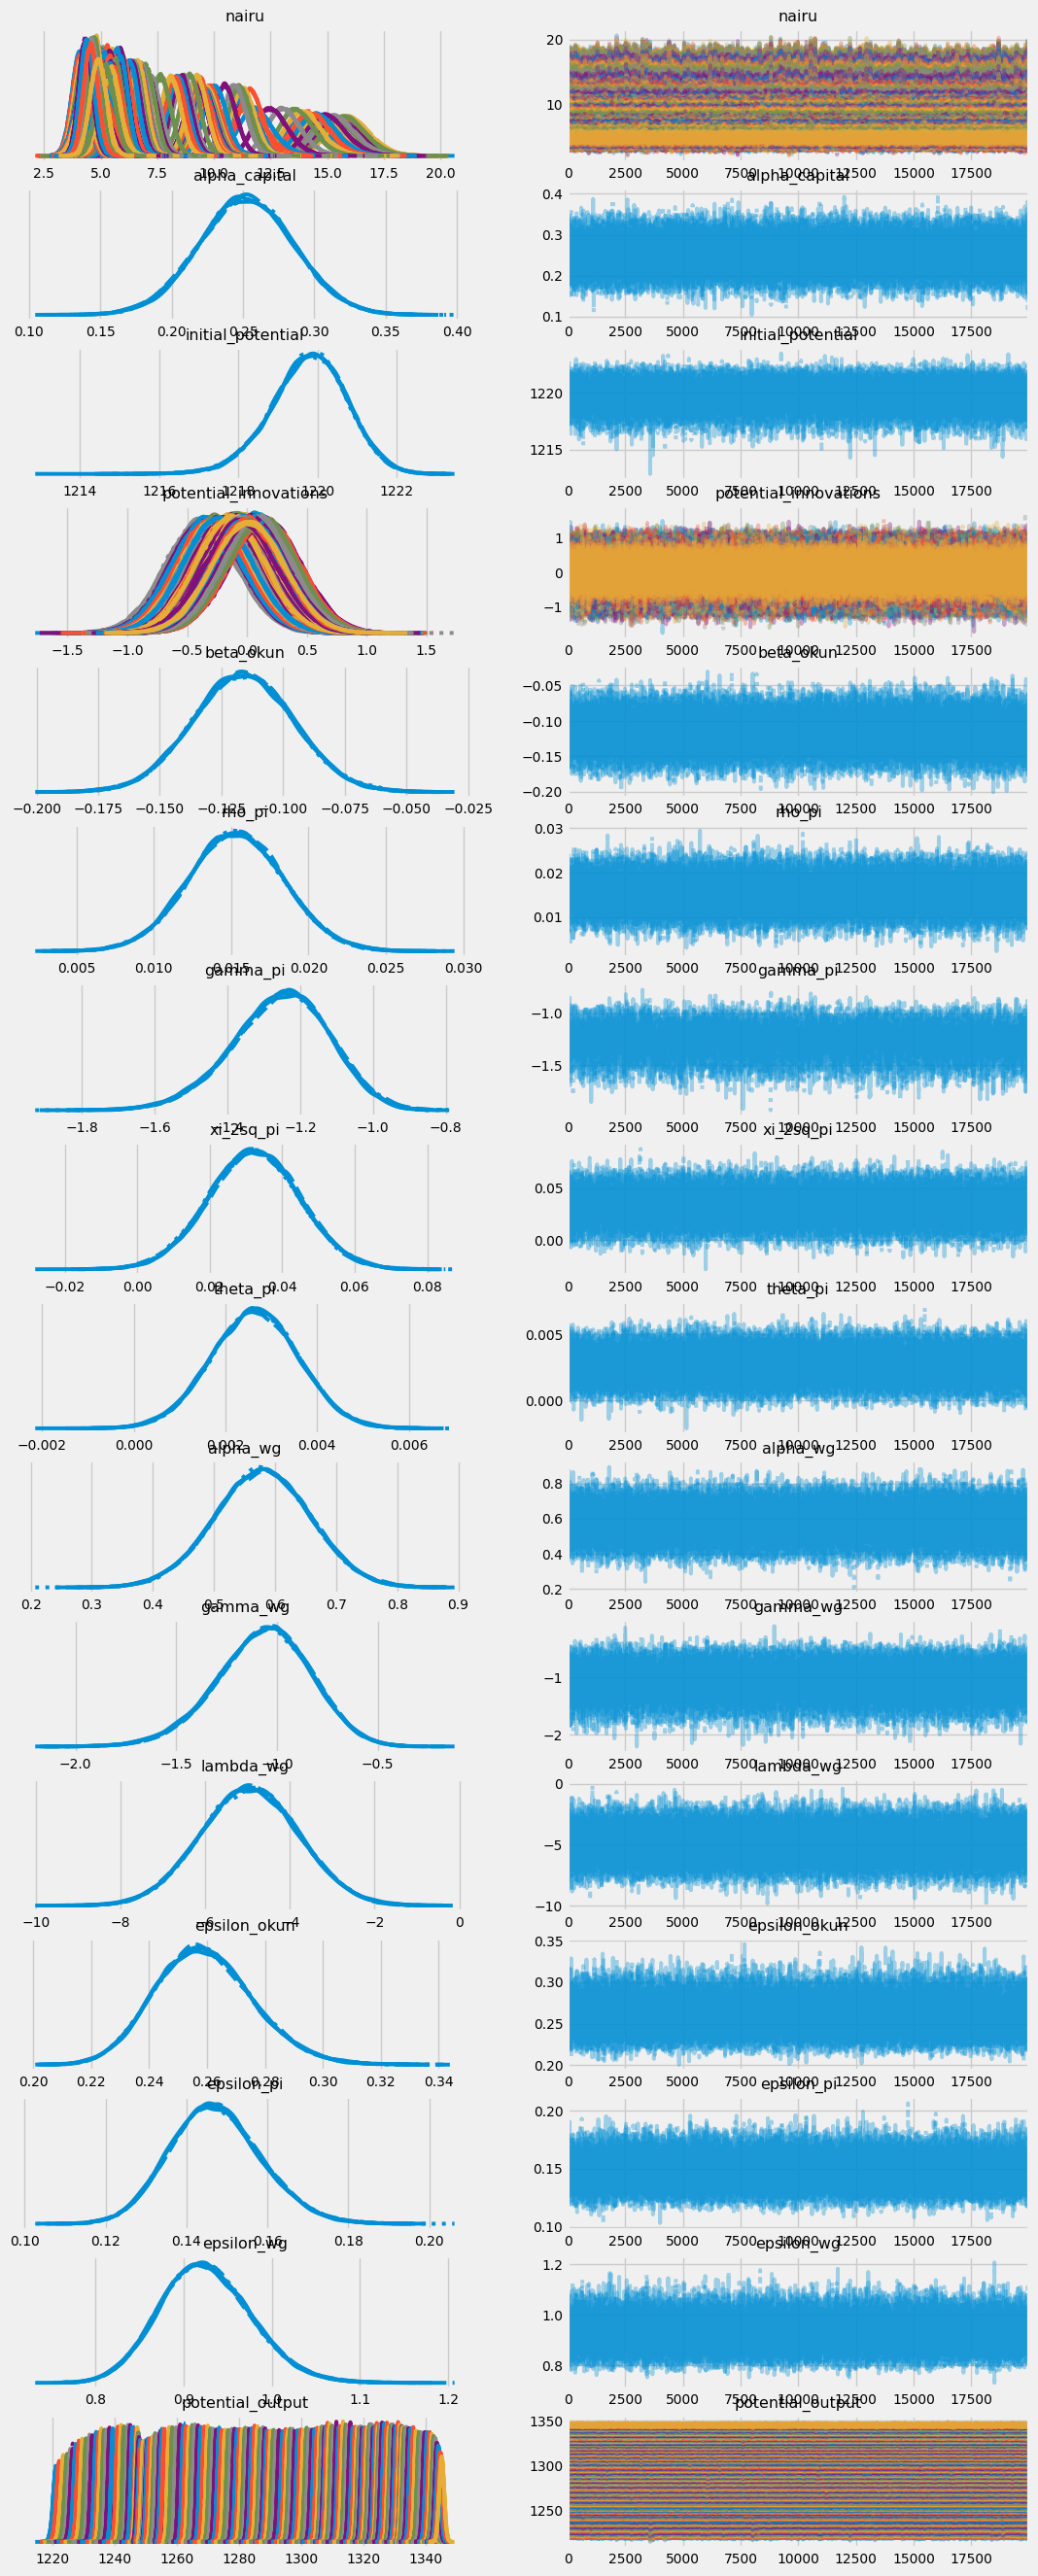

In [29]:
inference_data = fit_the_model(the_model, SAMPLE_ARGS)

### Check diagnostics from Bayesian model fitting

In [30]:
def check_inference_data(trace: az.InferenceData) -> None:
    """Check the inference data for potential problems.
    
    Diagnostics applied:
    - R-hat (Gelman-Rubin): Compares between-chain and within-chain variance.
      Values > 1.01 suggest chains have not converged to the same distribution.
    - ESS (Effective Sample Size): Estimates independent samples accounting for
      autocorrelation. Low ESS (< 400) indicates high autocorrelation or short chains.
    - MCSE/sd ratio: Monte Carlo standard error relative to posterior sd.
      Ratios > 5% suggest insufficient samples for reliable posterior mean estimates.
    - Divergent transitions: Indicate regions where the sampler struggled with
      posterior geometry. Any divergences may signal biased estimates.
    - Tree depth saturation: High rates at max tree depth suggest the sampler
      is working harder than expected, possibly due to difficult geometry.
    - BFMI (Bayesian Fraction of Missing Information): Measures how well the
      sampler explores the energy distribution. Values < 0.3 suggest poor exploration.
    """

    def warn(w: bool) -> str:
        return "--- THERE BE DRAGONS ---> " if w else ""

    summary = az.summary(trace)

    # check model convergence
    max_r_hat = 1.01
    statistic = summary.r_hat.max()
    print(
        f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}"
    )

    # check effective sample size
    min_ess = 400
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(
        f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {int(statistic)}"
    )

    # check MCSE ratio (should be < 5% of posterior sd)
    max_mcse_ratio = 0.05
    statistic = (summary["mcse_mean"] / summary["sd"]).max()
    print(
        f"{warn(statistic > max_mcse_ratio)}Maximum MCSE/sd ratio: {statistic:0.3f}"
    )

    # check for divergences (rate-based: < 1 in 10,000 samples)
    # Note: even one divergence might be problematic.
    max_divergence_rate = 1 / 10_000  # 0.01%
    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))
    except (ValueError, AttributeError):
        diverging_count = 0
    total_samples = trace.posterior.sizes["draw"] * trace.posterior.sizes["chain"]
    divergence_rate = diverging_count / total_samples
    print(
        f"{warn(divergence_rate > max_divergence_rate)}Divergent transitions: "
        f"{diverging_count}/{total_samples} ({divergence_rate:.4%})"
    )

    # check max tree depth saturation
    max_tree_depth_rate = 0.05  # warn if > 5% at max depth
    try:
        tree_depth = trace.sample_stats.tree_depth.values
        max_depth = int(tree_depth.max())
        at_max_rate = (tree_depth == max_depth).mean()
        print(
            f"{warn(at_max_rate > max_tree_depth_rate)}Tree depth at max ({max_depth}): "
            f"{at_max_rate:.2%}"
        )
    except AttributeError:
        pass  # Not all samplers report tree depth

    # check BFMI
    min_bfmi = 0.3
    statistic = az.bfmi(trace).min()
    print(
        f"{warn(statistic < min_bfmi)}Minimum Bayesian fraction of missing information: {statistic:0.2f}"
    )


check_inference_data(inference_data)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 5031
Maximum MCSE/sd ratio: 0.015
Divergent transitions: 0/100000 (0.0000%)
Tree depth at max (8): 0.07%
Minimum Bayesian fraction of missing information: 0.86


### Posterior Predictive Checks and Residual Analysis

In [31]:
def posterior_predictive_checks(
    trace: az.InferenceData,
    model: pm.Model,
    obs: dict[str, np.ndarray],
    obs_index: pd.PeriodIndex,
) -> az.InferenceData:
    """Generate and plot posterior predictive samples."""

    # Generate posterior predictive samples
    with model:
        ppc = pm.sample_posterior_predictive(trace, random_seed=42)

    # Observed variable names and their corresponding data
    obs_vars = {
        "okun_law": obs["ΔU"],
        "observed_price_inflation": obs["π"] - PI_TARGET_QUARTERLY,
        "observed_wage_growth": obs["Δulc"],
    }
    var_labels = {
        "okun_law": "Change in Unemployment (pp)",
        "observed_price_inflation": "Inflation Deviation from Target (pp)",
        "observed_wage_growth": "Unit Labour Cost Growth (%)",
    }

    for var_name, observed_data in obs_vars.items():
        # Extract posterior predictive samples
        ppc_samples = ppc.posterior_predictive[var_name].values
        # Shape: (chains, draws, time) -> flatten to (samples, time)
        ppc_flat = ppc_samples.reshape(-1, ppc_samples.shape[-1])

        ppc_mean = ppc_flat.mean(axis=0)
        ppc_05 = np.percentile(ppc_flat, 5, axis=0)
        ppc_95 = np.percentile(ppc_flat, 95, axis=0)
        ppc_16 = np.percentile(ppc_flat, 16, axis=0)
        ppc_84 = np.percentile(ppc_flat, 84, axis=0)

        # 90% CI band
        band_90 = pd.DataFrame(
            {"lower": ppc_05, "upper": ppc_95}, index=obs_index
        )
        ax = mg.fill_between_plot(
            band_90, color="steelblue", alpha=0.15, label="90% CI"
        )
        # 68% CI band
        band_68 = pd.DataFrame(
            {"lower": ppc_16, "upper": ppc_84}, index=obs_index
        )
        ax = mg.fill_between_plot(
            band_68, ax=ax, color="steelblue", alpha=0.25, label="68% CI"
        )
        # Predicted mean
        predicted = pd.Series(ppc_mean, index=obs_index, name="Predicted mean")
        mg.line_plot(predicted, ax=ax, color="steelblue", width=1.5)
        # Observed
        observed = pd.Series(observed_data, index=obs_index, name="Observed")
        mg.line_plot(observed, ax=ax, color="darkred", width=1)

        mg.finalise_plot(
            ax,
            title=f"Posterior Predictive Check: {var_labels[var_name]}",
            ylabel=var_labels[var_name],
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter="Blue: model prediction with credible intervals. Red: observed.",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )

    return ppc


ppc_data = posterior_predictive_checks(inference_data, the_model, obs, obs_index)

Sampling: [observed_price_inflation, observed_wage_growth, okun_law]


Output()

In [32]:
def residual_autocorrelation_analysis(
    ppc: az.InferenceData,
    obs: dict[str, np.ndarray],
    obs_index: pd.PeriodIndex,
    max_lags: int = 20,
) -> None:
    """Analyze residual autocorrelation for model validation.
    
    For state-space models, residuals should be approximately white noise
    (no significant autocorrelation).
    """
    from statsmodels.stats.diagnostic import acorr_ljungbox

    obs_vars = {
        "okun_law": obs["ΔU"],
        "observed_price_inflation": obs["π"] - PI_TARGET_QUARTERLY,
        "observed_wage_growth": obs["Δulc"],
    }
    var_labels = {
        "okun_law": "Okun's Law (ΔU)",
        "observed_price_inflation": "Price Inflation",
        "observed_wage_growth": "Wage Growth",
    }

    for var_name, observed_data in obs_vars.items():
        # Get posterior predictive mean
        ppc_samples = ppc.posterior_predictive[var_name].values
        ppc_flat = ppc_samples.reshape(-1, ppc_samples.shape[-1])
        ppc_mean = ppc_flat.mean(axis=0)

        # Calculate residuals
        residuals = observed_data - ppc_mean
        residuals_series = pd.Series(residuals, index=obs_index, name="Residuals")

        # Plot residuals over time with ±2σ band
        std_band = pd.DataFrame({
            "lower": np.full(len(obs_index), -2 * residuals.std()),
            "upper": np.full(len(obs_index), 2 * residuals.std()),
        }, index=obs_index)
        ax = mg.fill_between_plot(std_band, color="grey", alpha=0.1, label="±2σ")
        mg.line_plot(residuals_series, ax=ax, color="steelblue", width=0.8)
        
        # Ljung-Box test
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        p_value = lb_test["lb_pvalue"].values[0]
        status = "OK" if p_value > 0.05 else "AUTOCORRELATED"
        
        mg.finalise_plot(
            ax,
            title=f"Residuals: {var_labels[var_name]}",
            ylabel="Residual",
            lfooter=f"Ljung-Box test (lag 10): p={p_value:.4f} ({status})",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )

        # ACF plot using pandas Series acf
        n = len(residuals)
        acf_vals = np.correlate(residuals - residuals.mean(), residuals - residuals.mean(), mode="full")
        acf_vals = acf_vals[n - 1:] / acf_vals[n - 1]
        acf_series = pd.Series(acf_vals[:max_lags + 1], index=range(max_lags + 1), name="ACF")
        
        # Confidence bounds
        conf_bound = 1.96 / np.sqrt(n)
        conf_upper = pd.DataFrame({
            "lower": np.full(max_lags + 1, -conf_bound),
            "upper": np.full(max_lags + 1, conf_bound),
        }, index=range(max_lags + 1))
        
        ax = mg.fill_between_plot(conf_upper, color="red", alpha=0.1, label="95% CI")
        mg.line_plot(acf_series, ax=ax, color="steelblue", width=1.5)
        
        mg.finalise_plot(
            ax,
            title=f"Autocorrelation Function: {var_labels[var_name]}",
            ylabel="ACF",
            xlabel="Lag",
            lfooter="Red band: 95% confidence bounds for white noise.",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )

    # Print summary
    print("\nResidual Autocorrelation Summary:")
    print("-" * 50)
    for var_name, observed_data in obs_vars.items():
        ppc_samples = ppc.posterior_predictive[var_name].values
        ppc_mean = ppc_samples.reshape(-1, ppc_samples.shape[-1]).mean(axis=0)
        residuals = observed_data - ppc_mean
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        p_value = lb_test["lb_pvalue"].values[0]
        status = "OK" if p_value > 0.05 else "*** AUTOCORRELATED ***"
        print(f"{var_labels[var_name]:25} Ljung-Box p={p_value:.4f}  {status}")


residual_autocorrelation_analysis(ppc_data, obs, obs_index)


Residual Autocorrelation Summary:
--------------------------------------------------
Okun's Law (ΔU)           Ljung-Box p=0.0797  OK
Price Inflation           Ljung-Box p=0.4336  OK
Wage Growth               Ljung-Box p=0.8406  OK


## Model coefficient validation

* check all scalar coefficients differ from zero
* check values correspond with theoretical expectations

### Samples extraction

In [33]:
def get_vector_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a vector variable (e.g., nairu).
    Returns DataFrame with rows=time periods, columns=samples."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )


def get_scalar_var(var_name: str, trace: az.InferenceData) -> pd.Series:
    """Extract the chains/draws for a scalar variable (e.g., coefficients).
    Returns Series of posterior samples."""

    return az.extract(trace, var_names=var_name).to_dataframe()[var_name]

### Coefficients differ from zero

In [34]:
def print_parameter_summary(trace: az.InferenceData, model: pm.Model) -> None:
    """Print the summary results of the model."""

    q = [0.01, 0.05, 0.10, 0.25, 0.50]
    q_tail = [1 - x for x in q[:-1]][::-1]
    q = q + q_tail

    # Exclude vector variables
    vector_vars = ["nairu", "potential_output", "potential_innovations"]
    quantiles = {
        str(name): get_scalar_var(str(name), trace).quantile(q)
        for name in model.free_RVs
        if str(name) not in vector_vars
    }

    df = pd.DataFrame(quantiles).T.sort_index()
    problem_intensity = (
        pd.DataFrame(np.sign(df.T))
        .apply([lambda x: x.lt(0).sum(), lambda x: x.ge(0).sum()])
        .min()
        .astype(int)
    )
    marker = pd.Series(["*"] * len(problem_intensity), index=problem_intensity.index)
    markers = (
        marker.str.repeat(problem_intensity).reindex(problem_intensity.index).fillna("")
    )
    df["Check Significance"] = markers

    critical_params = ["gamma_pi", "gamma_wg", "beta_okun"]
    for param in df.index:
        if param in problem_intensity:
            stars = problem_intensity[param]
            if (stars > 0 if param in critical_params else stars > 2):
                print(
                    f"*** WARNING: Parameter '{param}' may be indistinguishable from zero "
                    f"({stars} stars). Check model specification! ***"
                )

    print("=" * 20)
    display(df)


print_parameter_summary(inference_data, the_model)

,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,Check Significance
alpha_capital,0.174690,0.197768,0.209859,0.230170,0.252257,0.274741,0.294934,0.307230,0.330208,
alpha_wg,0.396008,0.449791,0.479011,0.527000,0.579307,0.632018,0.679354,0.707375,0.760248,
beta_okun,-0.164228,-0.149703,-0.142336,-0.129915,-0.116247,-0.102415,-0.090016,-0.082526,-0.067840,
epsilon_okun,0.223464,0.232816,0.238134,0.247333,0.258351,0.270064,0.281284,0.288348,0.302220,
epsilon_pi,0.122965,0.129554,0.133181,0.139484,0.146814,0.154534,0.162050,0.166583,0.175473,
epsilon_wg,0.815314,0.844483,0.861221,0.889531,0.923247,0.959173,0.992946,1.013969,1.056989,
gamma_pi,-1.590366,-1.484626,-1.428632,-1.340770,-1.247537,-1.161526,-1.087129,-1.044586,-0.968616,
gamma_wg,-1.660518,-1.468021,-1.371660,-1.218965,-1.058330,-0.906901,-0.776201,-0.700378,-0.561087,
initial_potential,1217.278157,1218.116651,1218.519936,1219.156715,1219.805035,1220.423225,1220.956330,1221.274340,1221.854972,
lambda_wg,-7.591739,-6.829707,-6.424651,-5.725060,-4.946648,-4.165363,-3.463262,-3.045544,-2.284892,


### Hypothesis Tests for Theoretical Expectations

Test whether key parameters match theory: α ≈ 0.3 (capital share), β_okun < 0, γ_π < 0, γ_wg < 0.

In [35]:
def test_theoretical_expectations(trace: az.InferenceData) -> pd.DataFrame:
    """Test whether parameters match theoretical expectations.
    
    For parameters expected to equal a value (α≈0.3), we test:
        - Probability that parameter differs from expected value
        - Whether the expected value falls within the 90% HDI
    
    For parameters expected to have a sign (β<0, γ<0), we test:
        - Probability that parameter has the expected sign
    """
    
    results = []
    
    # Define tests: (parameter, expected_value or 'negative'/'positive', description)
    tests = [
        ('alpha_capital', 0.3, 'Capital share ≈ 0.3'),
        ('beta_okun', 'negative', 'Okun coefficient < 0'),
        ('gamma_pi', 'negative', 'Phillips curve slope < 0'),
        ('gamma_wg', 'negative', 'Wage Phillips curve slope < 0'),
    ]
    
    for param, expected, description in tests:
        samples = get_scalar_var(param, trace).values
        median = np.median(samples)
        hdi_90 = az.hdi(samples, hdi_prob=0.90)
        
        if isinstance(expected, (int, float)):
            # Test for equality to expected value
            in_hdi = hdi_90[0] <= expected <= hdi_90[1]
            prob_above = np.mean(samples > expected)
            prob_below = np.mean(samples < expected)
            
            results.append({
                'Parameter': param,
                'Hypothesis': description,
                'Median': f'{median:.3f}',
                '90% HDI': f'[{hdi_90[0]:.3f}, {hdi_90[1]:.3f}]',
                'Expected in HDI': '✓' if in_hdi else '✗',
                'P(θ > expected)': f'{prob_above:.1%}',
                'Result': 'PASS' if in_hdi else 'FAIL'
            })
        else:
            # Test for sign
            if expected == 'negative':
                prob_correct = np.mean(samples < 0)
                sign_check = median < 0
            else:
                prob_correct = np.mean(samples > 0)
                sign_check = median > 0
            
            results.append({
                'Parameter': param,
                'Hypothesis': description,
                'Median': f'{median:.3f}',
                '90% HDI': f'[{hdi_90[0]:.3f}, {hdi_90[1]:.3f}]',
                'Expected in HDI': '-',
                'P(correct sign)': f'{prob_correct:.1%}',
                'Result': 'PASS' if prob_correct > 0.99 else ('WEAK' if prob_correct > 0.90 else 'FAIL')
            })
    
    df = pd.DataFrame(results)
    return df


hypothesis_results = test_theoretical_expectations(inference_data)
display(hypothesis_results)

,Parameter,Hypothesis,Median,90% HDI,Expected in HDI,P(θ > expected),Result,P(correct sign)
0,alpha_capital,Capital share ≈ 0.3,0.252,"[0.198, 0.307]",✓,7.6%,PASS,NaN
1,beta_okun,Okun coefficient < 0,-0.116,"[-0.149, -0.082]",-,NaN,PASS,100.0%
2,gamma_pi,Phillips curve slope < 0,-1.248,"[-1.470, -1.031]",-,NaN,PASS,100.0%
3,gamma_wg,Wage Phillips curve slope < 0,-1.058,"[-1.453, -0.688]",-,NaN,PASS,100.0%


## Plotting

In [36]:
def plot_timeseies(
    trace: az.InferenceData | None = None,
    var: str | None = None,
    index: pd.PeriodIndex | None = None,
    data: pd.DataFrame | None = None,
    legend_stem: str = "Model Estimate",
    color: str = "blue",
    start: pd.Period | None = pd.Period("1985Q1", freq="Q"),
    cuts: Sequence[float] = [0.005, 0.025, 0.16],
    alphas: Sequence[float] = [0.1, 0.2, 0.3],
) -> Axes | None:
    """Plot time series with credible intervals.
    
    Can either fetch samples from trace using var name, or use pre-computed data.
    
    Args:
        trace: InferenceData object (required if data not provided)
        var: Variable name to extract from trace (required if data not provided)
        index: PeriodIndex for the time series (required if data not provided)
        data: Pre-computed samples DataFrame (rows=time, cols=samples)
        legend_stem: Label prefix for legend entries
        color: Color for bands and line
        start: Start period for plotting
        cuts: Quantile cuts for confidence bands (must be between 0 and 0.5)
        alphas: Alpha values for each confidence band
    """

    if len(cuts) != len(alphas):
        raise ValueError("Cuts and alphas must have the same length")

    # Get samples either from trace or use provided data
    if data is not None:
        samples = data
    elif trace is not None and var is not None and index is not None:
        samples = get_vector_var(var, trace)
        samples.index = index
    else:
        raise ValueError("Must provide either (trace, var, index) or data")

    if start is not None:
        samples = samples[samples.index >= start]

    ax: Axes | None = None
    for cut, alpha in zip(cuts, alphas):
        if not (0 < cut < 0.5):
            raise ValueError("Cuts must be between 0 and 0.5")
        
        lower = samples.quantile(q=cut, axis=1)
        upper = samples.quantile(q=1 - cut, axis=1)
        band = pd.DataFrame({"lower": lower, "upper": upper}, index=samples.index)
        ax = mg.fill_between_plot(
            band,
            ax=ax,
            color=color,
            alpha=alpha,
            label=f"{legend_stem} {int((1 - 2 * cut) * 100)}% Credible Interval",
        )
    
    median = samples.quantile(q=0.5, axis=1)
    median.name = f"{legend_stem} Median"
    ax = mg.line_plot(median, ax=ax, color=color, width=1, annotate=True)

    return ax

### Plot NAIRU

In [37]:
def plot_nairu(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    # --- NAIRU series
    start = pd.Period("1985Q1", freq="Q")
    ax = plot_timeseies(
        trace=trace,
        var="nairu",
        index=input_index,
        legend_stem="NAIRU",
        color="blue",
        start=start,
    )

    # --- unemployment and inflation rates - white background then series
    u = unemployment[unemployment.index >= start]
    inflation = π4[π4.index >= start]
    back, front = 3, 1.5
    for color, width, label in zip(["white", ""], [back, front], ["_", ""]):
        u.name = "Unemployment Rate" if not label else label
        mg.line_plot(
            u,
            ax=ax,
            color=color if color else "brown",
            width=width,
        )
        inflation.name = "Inflation rate" if not label else label
        mg.line_plot(
            inflation,
            ax=ax,
            color=color if color else "darkorange",
            width=width,
        )

    # --- finalise plot
    if ax is not None:
        mg.finalise_plot(
            ax,
            title="NAIRU Estimate for Australia (Joint Model)",
            ylabel="Per cent",
            legend={"loc": "best", "fontsize": "x-small"},
            lfooter="Australia. ",
            rfooter=RFOOTER_OUTPUT,
            axvspan={"xmin": start.ordinal, "xmax": pd.Period("1993Q2", freq="Q").ordinal, 
                     "color": "goldenrod", "alpha": 0.25, "zorder": -1, 
                     "label": "Pre-inflation targeting (treat estimates with caution)"},
            **ANNUAL_RANGE,
            **ANNUAL_TARGET,
            show=SHOW,
        )


plot_nairu(inference_data, U, obs_index)

### Plot Unemployment Gap

* Above zero (positive): Slack - unemployment too high, disinflationary pressure
* Below zero (negative): Tight - unemployment too low, inflationary pressure

In [38]:
def plot_unemployment_gap(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the unemployment gap (U - U*)."""

    start = pd.Period("1985Q1", freq="Q")
    
    # Get NAIRU samples and calculate unemployment gap for each sample
    nairu = get_vector_var("nairu", trace)
    nairu.index = input_index
    u_gap = nairu.apply(lambda col: unemployment - col)
    print("Last data point:", u_gap.index[-1])
    
    # Plot using shared time series function
    ax = plot_timeseies(
        data=u_gap,
        legend_stem="Unemployment Gap",
        color="darkred",
        start=start,
    )
    
    # Finalise plot
    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Unemployment Gap Estimate for Australia",
            ylabel="Percentage points (U - U*)",
            lfooter="Australia. U - U*. Positive = slack/disinflationary, Negative = tight/inflationary.",
            rfooter=RFOOTER_OUTPUT,
            legend={"loc": "best", "fontsize": "x-small"},
            y0=True,
            axvspan={"xmin": start.ordinal, "xmax": pd.Period("1993Q2", freq="Q").ordinal, 
                     "color": "goldenrod", "alpha": 0.25, "zorder": -1, 
                     "label": "Pre-inflation targeting (treat estimates with caution)"},
            show=SHOW,
        )


plot_unemployment_gap(inference_data, U, obs_index)

Last data point: 2025Q3


### Plot Output Gap

* Above zero (positive): Overheating - GDP above potential, inflationary pressure
* Below zero (negative): Slack - GDP below potential, disinflationary pressure

In [39]:
def plot_output_gap(
    trace: az.InferenceData,
    log_gdp: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the output gap as percentage deviation from potential."""

    start = pd.Period("1985Q1", freq="Q")
    
    # Get potential output samples and calculate output gap for each sample
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index
    
    # Calculate output gap: (Y - Y*)/Y* * 100
    actual_gdp = log_gdp.reindex(input_index).values
    output_gap = (actual_gdp[:, np.newaxis] - potential.values) / potential.values * 100
    output_gap = pd.DataFrame(output_gap, index=input_index)
    
    # Plot using shared time series function
    ax = plot_timeseies(
        data=output_gap,
        legend_stem="Output Gap",
        color="green",
        start=start,
    )
    
    # Finalise plot
    if ax is not None:
        ax.axhline(y=0, color="darkred", linestyle="--", linewidth=1)
        mg.finalise_plot(
            ax,
            title="Output Gap Estimate for Australia",
            ylabel="Per cent of potential GDP",
            legend={"loc": "best", "fontsize": "x-small"},
            lfooter="Australia. (log Y - log Y*) / log Y* × 100. Positive = overheating/inflationary.",
            rfooter=RFOOTER_OUTPUT,
            show=SHOW,
        )


plot_output_gap(inference_data, log_GDP, obs_index)

### Plot Actual vs Potential GDP

In [40]:
def plot_gdp_vs_potential(
    trace: az.InferenceData,
    log_gdp: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot actual GDP against potential GDP estimates."""

    # Get potential output samples
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # Plot potential GDP using shared time series function
    ax = plot_timeseies(
        data=potential,
        legend_stem="Potential GDP",
        color="green",
        start=pd.Period("1985Q1", freq="Q"),
    )

    # Plot actual GDP on top
    actual = log_gdp.reindex(input_index)
    actual.name = "Actual GDP"
    mg.line_plot(
        actual,
        ax=ax,
        color="black",
        width=1.5,
    )

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Actual vs Potential GDP",
            ylabel="Log GDP (scaled)",
            legend={"loc": "upper left", "fontsize": "x-small"},
            lfooter="Australia. Log real GDP scaled by 100. ",
            rfooter=RFOOTER_OUTPUT,
            show=SHOW,
        )


plot_gdp_vs_potential(inference_data, log_GDP, obs_index)

### Plot Potential Growth (proxy for r*)

In [41]:
def plot_potential_growth(
    trace: az.InferenceData,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot annual potential GDP growth (4Q difference of log potential).

    This serves as a proxy for r* (the natural rate of interest), based on
    the theoretical relationship r* ≈ trend real GDP growth.

    It is also the maximum rate at which we can run economic growth before
    inflationary pressures build up.
    """
    from scipy import stats

    # Get potential output samples and calculate annual growth
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # Calculate annual potential growth: 4Q difference of log potential
    # Since potential is log(GDP)*100, the diff is already in percentage points
    potential_growth = potential.diff(4).dropna()

    # Plot using shared time series function
    ax = plot_timeseies(
        data=potential_growth,
        legend_stem="Potential Growth",
        color="purple",
        start=pd.Period("1985Q1", freq="Q"),
    )

    # Add regression trend line on median
    median_growth = potential_growth.quantile(0.5, axis=1)
    x_numeric = np.arange(len(median_growth))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, median_growth.values)
    trend_line = pd.Series(intercept + slope * x_numeric, index=median_growth.index)
    trend_line.name = f"Trend (slope: {slope * 4:.2f}pp/year)"
    mg.line_plot(
        trend_line,
        ax=ax,
        color="darkred",
        width=1.5,
        style="--",
    )

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Potential GDP Growth Rate (proxy for $r^*$)",
            ylabel="Per cent per annum",
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter="Australia. 4-quarter change in log potential GDP. r* ≈ trend growth.",
            rfooter="AKA: Non-inflationary GDP growth rate. ",
            rheader=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )


plot_potential_growth(inference_data, obs_index)

### Taylor Rule Assessment

Compare actual policy rates to Taylor Rule prescription: $i_t = r^* + \pi_{coef} \cdot \pi_t - 0.5\pi^* + 0.5 \cdot y_{gap}$

The time-varying $\pi_{coef}$ (1.6->1.25) reflects the shift from establishing inflation-fighting credibility in the pre-targeting era to a more balanced approach under flexible inflation targeting. Higher coefficients were appropriate when the RBA needed to anchor expectations; lower coefficients suit an era of established credibility with a target band rather than point target.

See [NAIRU+Output Gap model.md](NAIRU+Output%20Gap%20model.md) for methodology and caveats.

In [42]:
def plot_taylor_rule(
    trace: az.InferenceData,
    inflation_annual: pd.Series,
    cash_rate_monthly: pd.Series,
    input_index: pd.PeriodIndex,
    pi_target: float = 2.5,
    pi_coef_start: float = 1.6,
    pi_coef_end: float = 1.25,
    r_star_trend_weight: float = 0.75,
) -> None:
    """Plot Taylor Rule prescribed rate vs actual RBA cash rate.
    
    Taylor Rule: i = r* + π_coef·π - 0.5·π* + 0.5·y_gap
    """

    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # r* = annual potential growth
    r_star = potential.diff(4).dropna()

    # Smooth r* toward trend
    if r_star_trend_weight > 0:
        median = r_star.quantile(0.5, axis=1)
        slope, intercept, *_ = stats.linregress(np.arange(len(median)), median.values)
        trend = intercept + slope * np.arange(len(median))
        w = r_star_trend_weight
        r_star = r_star.multiply(1 - w).add(trend * w, axis=0)

    # Output gap: (Y - Y*)/Y* × 100
    actual_gdp = log_GDP.reindex(input_index).values
    output_gap = (actual_gdp[:, np.newaxis] - potential.values) / potential.values * 100
    output_gap = pd.DataFrame(output_gap, index=input_index, columns=potential.columns)
    output_gap = output_gap.reindex(r_star.index)

    # Time-varying inflation coefficient
    pi = inflation_annual.reindex(r_star.index)
    pi_coef = pd.Series(
        np.linspace(pi_coef_start, pi_coef_end, len(r_star)),
        index=r_star.index
    )

    # Taylor Rule for each sample
    taylor = (
        r_star
        .add(pi_coef * pi, axis=0)
        .add(-0.5 * pi_target)
        .add(output_gap.multiply(0.5))
    ).dropna()

    # Convert to monthly for cash rate alignment
    monthly_idx = taylor.index.to_timestamp(how='end').to_period('M')
    taylor_monthly = taylor.copy()
    taylor_monthly.index = monthly_idx

    # Plot
    ax = plot_timeseies(
        data=taylor_monthly,
        legend_stem="Taylor Rule",
        color="darkblue",
        start=None,
    )

    cash_rate_monthly.name = "RBA Cash Rate"
    mg.line_plot(cash_rate_monthly, ax=ax, color="#dd0000", width=1,
                drawstyle="steps-post", annotate=True)

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Taylor Rule vs RBA Cash Rate",
            ylabel="Per cent per annum",
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter=f"Australia. Taylor Rule: i = r* + π_coef·π - 0.5π* + 0.5·y_gap; "
                    +f"π_coef={pi_coef_start}→{pi_coef_end}",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )


plot_taylor_rule(inference_data, π4, cash_rate_monthly, obs_index)  

### Plot Coefficient Posteriors

In [43]:
def auto_scale(samples, median):
    threshold = 1.3  # let's not scale small values near 1
    if abs(median) <= threshold:
        return samples, 1
    scale = 10 ** math.floor(math.log10(abs(median*10)))
    return samples / scale, max(int(scale), 1)

In [44]:
def plot_coefficient_posteriors(trace: az.InferenceData, model: pm.Model) -> None:
    """Plot horizontal bar chart of coefficient posteriors."""
    
    vector_vars = ["nairu", "potential_output", "potential_innovations"]
    var_names = [str(name) for name in model.free_RVs if str(name) not in vector_vars]
    
    posteriors = {}
    labels = {}
    all_significant_99 = True
    all_significant_95 = True
    for var in var_names:
        samples = get_scalar_var(var, trace)
        median = samples.quantile(0.5)
        
        # Check 99% significance
        if median < 0:
            if samples.quantile(0.99) >= 0:
                all_significant_99 = False
            if samples.quantile(0.95) >= 0:
                all_significant_95 = False
        else:
            if samples.quantile(0.01) <= 0:
                all_significant_99 = False
            if samples.quantile(0.05) <= 0:
                all_significant_95 = False
        
        scaled_samples, scale = auto_scale(samples, median)
        if scale != 1:
            posteriors[var] = scaled_samples
            labels[var] = f"{var}/{scale}"
        else:
            posteriors[var] = samples
            labels[var] = var

    
    cuts = [2.5, 16]
    palette = "Blues"
    cmap = plt.get_cmap(palette)
    color_fracs = [0.4, 0.7]
    
    fig, ax = plt.subplots(figsize=(10, len(var_names) * 0.6 + 1))
    
    y_positions = range(len(var_names))
    bar_height = 0.7
    
    sorted_vars = sorted(var_names)
    for i, var in enumerate(sorted_vars):
        samples = posteriors[var]
        
        for j, p in enumerate(cuts):
            quants = (p, 100 - p)
            lower = samples.quantile(quants[0] / 100.0)
            upper = samples.quantile(quants[1] / 100.0)
            height = bar_height * (1 - j * 0.25)
            
            ax.barh(
                i,
                width=upper - lower,
                left=lower,
                height=height,
                color=cmap(color_fracs[j]),
                alpha=0.7,
                label=f"{quants[1] - quants[0]:.0f}% HDI" if i == 0 else "_",
                zorder=j + 1,
            )
        
        median = samples.quantile(0.5)
        ax.vlines(
            median, i - bar_height/2, i + bar_height/2,
            color="black", linestyle="--", linewidth=1, zorder=10,
            label="Median" if i == 0 else "_"
        )
        ax.text(
            median, i + bar_height/2 + 0.05,
            f"{median:.3f}",
            ha="center", va="bottom",
            fontsize=8, color="black"
        )
    
    ax.axvline(x=0, color="darkred", linestyle="--", linewidth=1.5, zorder=15)
    ax.set_yticks(list(y_positions))
    ax.set_yticklabels([labels[var] for var in sorted_vars])
    ax.invert_yaxis()
    
    lfooter = "Some variables have been scaled (as indicated)."
    if all_significant_99:
        lfooter += " All coefficients are different from zero (>99% probability)."
    elif all_significant_95:
        lfooter += " All coefficients are different from zero (>95% probability)."
    
    mg.finalise_plot(
        ax,
        title="Model Coefficient Posteriors",
        xlabel="Coefficient value",
        legend={"loc": "best", "fontsize": "x-small"},
        lfooter=lfooter,
        rfooter=RFOOTER_OUTPUT,
        show=SHOW,
    )


plot_coefficient_posteriors(inference_data, the_model)

### Plot individual KDEs for each posterior coefficient

In [45]:
def plot_coefficient_kde(trace: az.InferenceData, model: pm.Model) -> None:
    """Plot separate Kernel Density Estimates for each coefficient posterior."""
    
    from scipy import stats
    
    # Get non-vector free variables
    vector_vars = ["nairu", "potential_output", "potential_innovations"]
    var_names = [str(name) for name in model.free_RVs if str(name) not in vector_vars]
    
    for var in sorted(var_names):
        fig, ax = plt.subplots()
        samples = get_scalar_var(var, trace)
        
        # Plot KDE
        samples.plot.kde(ax=ax, color="steelblue", linewidth=2)
        
        # Fill under the curve
        kde = stats.gaussian_kde(samples)
        x_range = np.linspace(samples.min(), samples.max(), 200)
        kde_values = kde(x_range)
        ax.fill_between(x_range, kde_values, alpha=0.3, color="steelblue")
        
        # Add vertical line at zero
        ax.axvline(x=0, color="darkred", linestyle="--", linewidth=1.5)
        
        # Add median line
        median = samples.quantile(0.5)
        ax.axvline(x=median, color="black", linestyle="--", linewidth=1, alpha=0.7)
        
        # Add median value text at x=median, y=KDE maxima
        max_y = kde_values.max()
        ax.text(
            median, max_y,
            f"{median:.3f}",
            ha="center", va="bottom",
            fontsize=9, color="black"
        )
        
        mg.finalise_plot(
            ax,
            title=f"Posterior Distribution: {var}",
            ylabel="Density",
            xlabel="Coefficient value",
            lfooter="Red dashed line marks zero. Black dashed line marks median.",
            rfooter=RFOOTER_OUTPUT,
            tag=var,
            show=SHOW,
        )


plot_coefficient_kde(inference_data, the_model)

## Finished

In [46]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-12-09 15:12:29

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

IPython   : 9.8.0
typing    : 3.10.0.0
readabs   : 0.1.7
pymc      : 5.26.1
pandas    : 2.3.3
scipy     : 1.16.3
arviz     : 0.22.0
mgplot    : 0.2.13
numpy     : 2.3.5
matplotlib: 3.10.7

Watermark: 2.5.0

